In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
from scipy.stats import sem
# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_drug_data=pd.read_csv(mouse_drug_data_to_load)
clinical_trial_data=pd.read_csv(clinical_trial_data_to_load)
mouse_drug_data.head()
clinical_trial_data.head()

,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn
2,a492,Stelasyn
3,w540,Stelasyn
4,v764,Stelasyn


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


## Now, we have the following tasks:

> -  Creating a scatter plot that shows how the tumor volume changes over time for each treatment.
-  Creating a scatter plot that shows how the number of metastatic (cancer spreading) sites -  changes over time for each treatment.
-  Creating a scatter plot that shows the number of mice still alive through the course of treatment (Survival Rate)
-  Creating a bar graph that compares the total % tumor volume change for each drug across the full 45 days.



### Firstly, clean the data, ensure: 
     (1) each mouse takes only one kind of drug. (2) at any timepoint, only one measurement(row of data) for each mouse is performed. 

In [2]:
#expand the vector from groupby.count() object to the original length:
#https://stackoverflow.com/questions/30244952/python-pandas-create-new-column-with-groupby-sum/30244979
mouse_drug_data["times"]=mouse_drug_data["Mouse ID"].groupby(mouse_drug_data["Mouse ID"]).transform('count')

##delete the mouse_ID which appear more than one time in mouse_drug_data: 
mouse_drug_data=mouse_drug_data[mouse_drug_data["times"]==1]

##delete the rows for a particular mouse_ID for which multiple data for any timepoint is given:
for i in range(len(mouse_drug_data)):
    mouse_ID=mouse_drug_data["Mouse ID"].values[i]
    ss=clinical_trial_data[clinical_trial_data["Mouse ID"]==mouse_ID].copy()
    if not(all(ss["Timepoint"].value_counts())==1):
        clinical_trial_data.drop(clinical_trial_data["Mouse ID"]==mouse_ID,inplace=True)
    del ss

drug_to_test=["Capomulin", "Infubinol", "Ketapril", "Placebo"]
valid_Data_all_drugs=clinical_trial_data.merge(mouse_drug_data,on="Mouse ID")
valid_Data_all_drugs.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug,times
0,b128,0,45.000000,0,Capomulin,1
1,b128,5,45.651331,0,Capomulin,1
2,b128,10,43.270852,0,Capomulin,1
3,b128,15,43.784893,0,Capomulin,1
4,b128,20,42.731552,0,Capomulin,1


## Tumor Response to Treatment

In [3]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
Mean_Data_gp=valid_Data_all_drugs.groupby(["Drug","Timepoint"]).mean();

# Convert to DataFrame
mean_Tumor_Volume_Data_df=Mean_Data_gp["Tumor Volume (mm3)"].to_frame().reset_index()

# Preview DataFrame
mean_Tumor_Volume_Data_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,45.000000
1,Capomulin,5,44.266086
2,Capomulin,10,43.084291
3,Capomulin,15,42.064317
4,Capomulin,20,40.716325


In [4]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
sem_Data_gp=valid_Data_all_drugs.groupby(["Drug","Timepoint"]).sem();

# Convert to DataFrame
sem_Tumor_Volume_Data_df=sem_Data_gp["Tumor Volume (mm3)"].to_frame().reset_index()

# Preview DataFrame

sem_Tumor_Volume_Data_df.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [5]:
# Minor Data Munging to Re-Format the Data Frames
Re_formatted_mean_Tumor_Volume_Data_df=mean_Tumor_Volume_Data_df.pivot(index="Timepoint",columns="Drug",values="Tumor Volume (mm3)")
Re_formatted_sem_Tumor_Volume_Data_df = sem_Tumor_Volume_Data_df.pivot(index="Timepoint",columns="Drug",values="Tumor Volume (mm3)")

# Preview that Reformatting worked
Re_formatted_mean_Tumor_Volume_Data_df.head()
drug_list=Re_formatted_mean_Tumor_Volume_Data_df.columns
#Re_formatted_sem_Tumor_Volume_Data_df.columns


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.168130,43.944859,47.470830,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,48.938560,42.531957,49.335368,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,50.891769,41.495061,51.448025,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.127384,40.238325,53.970080,53.170334


10

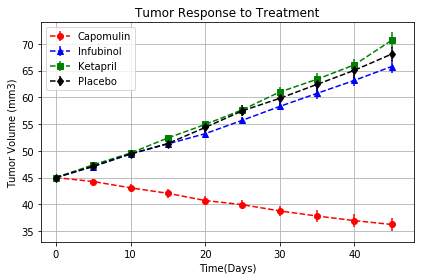

In [6]:
# Generate the Plot (with Error Bars)
fig, ax = plt.subplots()
x_axis=[index for index in Re_formatted_mean_Tumor_Volume_Data_df.index]
num_columns=len(drug_list)
num_columns
means=[(Re_formatted_mean_Tumor_Volume_Data_df.iloc[:,i]).values for i in range(num_columns)]
standard_errors=[(Re_formatted_sem_Tumor_Volume_Data_df.iloc[:,i]).values \
                 for i in range(num_columns)];
ss=[i for i in range(num_columns) if (drug_list[i] in drug_to_test)]
#drug_list[ss]

s1=ax.errorbar(x_axis, means[ss[0]], standard_errors[ss[0]], fmt="ro",ls='dashed',label="Capomulin");
s2=ax.errorbar(x_axis, means[ss[1]], standard_errors[ss[1]], fmt="b^",ls='--',label="Infubinol");
s3=ax.errorbar(x_axis, means[ss[2]], standard_errors[ss[2]], fmt="gs",ls='--',label="Ketapril");
s4=ax.errorbar(x_axis, means[ss[3]], standard_errors[ss[3]], fmt="kd",ls='--',label="Placebo");
ax.lines[1].set_markersize(6.0)
ax.grid()
legend=ax.legend(loc="best")
title=ax.set_title("Tumor Response to Treatment");
xlabel=ax.set_xlabel("Time(Days)")
ylabel=ax.set_ylabel("Tumor Volume (mm3)")
xlim=ax.set_xlim(-2,48)
ylim=ax.set_ylim(33,74)
# Save the Figure
fig.savefig('Mean_Tumor_Volume_4_test_drug.png')
plt.tight_layout()
#plt.show()

## Metastatic Response to Treatment

In [8]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 

# Convert to DataFrame
Mean_met_Site_Data_df=Mean_Data_gp['Metastatic Sites'].to_frame()
# Preview DataFrame
Mean_met_Site_Data_df.head()

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.160000
          10                 0.320000
          15                 0.375000
          20                 0.652174

In [9]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 
#sem_Data_gp
# Convert to DataFrame
sem_met_Site_Data_df=sem_Data_gp['Metastatic Sites'].to_frame()
# Preview DataFrame
sem_met_Site_Data_df.head()

Metastatic Sites
Drug      Timepoint                  
Capomulin 0                  0.000000
          5                  0.074833
          10                 0.125433
          15                 0.132048
          20                 0.161621

In [10]:
# Minor Data Munging to Re-Format the Data Frames

Re_formatted_Mean_met_Site_Data_df=Mean_met_Site_Data_df.reset_index().pivot(index="Timepoint",columns="Drug",values="Metastatic Sites")
Re_formatted_sem_met_Site_Data_df = sem_met_Site_Data_df.reset_index().pivot(index="Timepoint",columns="Drug",values="Metastatic Sites")



# Preview that Reformatting worked
Re_formatted_Mean_met_Site_Data_df.head(10)
#Re_formatted_Mean_met_Site_Data_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.384615,0.652174,1.166667,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.666667,0.782609,1.411765,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.333333,0.952381,1.533333,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


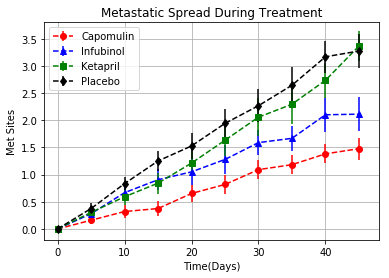

In [11]:
# Generate the Plot (with Error Bars)
fig, ax = plt.subplots()


means=[(Re_formatted_Mean_met_Site_Data_df.iloc[:,i]).values for i in range(num_columns)]
standard_errors=[(Re_formatted_sem_met_Site_Data_df.iloc[:,i]).values \
                 for i in range(num_columns)];


ss=[i for i in range(num_columns) if (drug_list[i] in drug_to_test)]
s1=ax.errorbar(x_axis, means[ss[0]], standard_errors[ss[0]], fmt="ro",ls='dashed',label="Capomulin");
s2=ax.errorbar(x_axis, means[ss[1]], standard_errors[ss[1]], fmt="b^",ls='--',label="Infubinol");
s3=ax.errorbar(x_axis, means[ss[2]], standard_errors[ss[2]], fmt="gs",ls='--',label="Ketapril");
s4=ax.errorbar(x_axis, means[ss[3]], standard_errors[ss[3]], fmt="kd",ls='--',label="Placebo");
ax.lines[1].set_markersize(6.0)
ax.grid()
legend=ax.legend(loc="best")
title=ax.set_title("Metastatic Spread During Treatment");
xlabel=ax.set_xlabel("Time(Days)")
ylabel=ax.set_ylabel("Met Sites")
xlim=ax.set_xlim(-2,48)
ylim=ax.set_ylim(-0.2,3.8)
# Save the Figure
fig.savefig('Mean_met_Site_4_test_drug.png')


## Survival Rates

In [12]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
sum_Data_gp=valid_Data_all_drugs.groupby(["Drug","Timepoint"]).count();
# Convert to DataFrame
sum_mouse_count_Data_df=sum_Data_gp["Mouse ID"].to_frame().reset_index().\
                 rename(columns={"Mouse ID":"Mouse count"});
# Preview DataFrame
sum_mouse_count_Data_df.head()

,Drug,Timepoint,Mouse count
0,Capomulin,0,25
1,Capomulin,5,25
2,Capomulin,10,25
3,Capomulin,15,24
4,Capomulin,20,23


In [13]:
# Minor Data Munging to Re-Format the Data Frames
Re_formatted_sum_mouse_count_Data_df=sum_mouse_count_Data_df.pivot(index="Timepoint",columns="Drug",values="Mouse count")
# Preview the Data Frame
Re_formatted_sum_mouse_count_Data_df.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,24,25,24,25
5,25,21,25,23,23,24,23,25,23,24
10,25,20,21,22,21,24,21,24,21,22
15,24,19,21,19,21,20,15,24,21,21
20,23,18,20,19,20,19,15,23,19,17


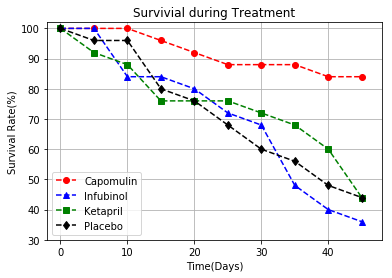

In [14]:
# Generate the Plot (Accounting for percentages)


fig, ax = plt.subplots()
#ss=Re_formatted_sum_mouse_count_Data_df.applymap(pd.to_numeric)

ss=Re_formatted_sum_mouse_count_Data_df.copy()

for i in range(len(ss)):
   Re_formatted_sum_mouse_count_Data_df.iloc[i,:]=ss.iloc[i,:]/ss.iloc[0,:]  
#Re_formatted_sum_mouse_count_Data_df=Re_formatted_sum_mouse_count_Data_df.applymap(pd.to_numeric;
#lambda x: "{0:.0f}".format(x * 100.0)
means=[(Re_formatted_sum_mouse_count_Data_df.iloc[:,i]).values*100 for i in range(num_columns)]

ss=[i for i in range(num_columns) if (drug_list[i] in drug_to_test)]
#drug_list[ss]
s1=ax.plot(x_axis, means[ss[0]],  marker="o",color='r',ls='dashed',label="Capomulin");
s2=ax.plot(x_axis, means[ss[1]],  marker="^",color='b',ls='--',label="Infubinol");
s3=ax.plot(x_axis, means[ss[2]],  marker="s",color='g',ls='--',label="Ketapril");
s4=ax.plot(x_axis, means[ss[3]],  marker="d",color='k',ls='--',label="Placebo");
s5=ax.lines[1].set_markersize(6.0)
ax.grid()
legend=ax.legend(loc="best")
title=ax.set_title("Survivial during Treatment");
ylim=ax.set_ylim(30, 104)
xlabel=ax.set_xlabel("Time(Days)")
ylabel=ax.set_ylabel("Survival Rate(%)")
xlim=ax.set_xlim(-2,48)
ylim=ax.set_ylim(30,102)
# Save the Figure
fig.savefig('Mouse_count_4_test_drug.png')


## Summary Bar Graph

In [25]:
# Calculate the percent changes for each drug
N_len=len(Re_formatted_mean_Tumor_Volume_Data_df)
change_percentage_Tumor_Volumn=(Re_formatted_mean_Tumor_Volume_Data_df.iloc[i,:]-Re_formatted_mean_Tumor_Volume_Data_df.iloc[0,:])\
   /Re_formatted_mean_Tumor_Volume_Data_df.iloc[0,:]


# Display the data to confirm
change_percentage_Tumor_Volumn


Drug
Capomulin   -0.194753
Ceftamin     0.425165
Infubinol    0.461235
Ketapril     0.570288
Naftisol     0.539233
Placebo      0.512980
Propriva     0.472412
Ramicane    -0.223209
Stelasyn     0.520851
Zoniferol    0.465798
dtype: float64

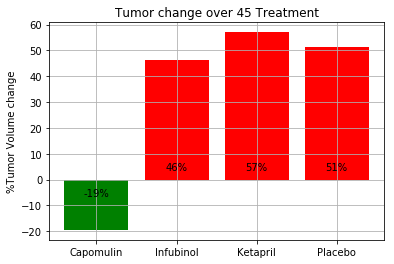

In [30]:
# Store all Relevant Percent Changes into a Tuple
v=change_percentage_Tumor_Volumn.copy()
Percentage_tuple=tuple(zip(v.index,v))

# Splice the data between passing and failing drugs
ss=[i for i in range(num_columns) if (drug_list[i] in drug_to_test)]
percentage_4test_drugs=[Percentage_tuple[ss[i]] for i in range(4)]
drug_4=[drug for drug,per in percentage_4test_drugs];
x_axis=[i for i in range(len(drug_4))]
percentage_4=[per*100 for drug,per in percentage_4test_drugs];

# %matplotlib inline
# import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bar1=ax.bar(x_axis,percentage_4,color=['g']+3*['r'] )
xticks=ax.set_xticks(np.arange(4))
xticks_label=ax.set_xticklabels(tuple(drug_4))
ax.grid()


title=ax.set_title("Tumor change over 45 Treatment");
ylabel=ax.set_ylabel("%Tumor Volume change")

# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes
##https://matplotlib.org/examples/api/barchart_demo.html
def labelbar(x,y,t):
    ax.text(x, y,t,ha='center', va='bottom')

x=ax.get_xticks()
y=[-7]+3*[3]
t=np.round(percentage_4)
for i in range(len(x)):
    labelbar(x[i],y[i],str(int(t[i]))+"%")
# Save the Figure
fig.savefig('Tumor_change_over_45_treatments_Bar_Chart.png')


## Observations:
> -  Capomulin is the only effective drug that can cause tumor reduction.
-  About two thirds of mices taking any of Infubinol, Ketapril, and Placebo drugs were dead at the 45th day. However, the corresponding survival rate for Capomulin taken mice are above 80%.
-  The spread of metastatic (cancer spreading) sites for Capomulin taken mice is also significantly smaller and slower than that of mice taking other drugs. 